In [1]:
import matplotlib.pyplot as plt

print("Begin init")
%run -i notebook/init_notebook.ipynb


import pandas as pd
import numpy as np

from structlog import get_logger
from tqdm import tqdm


from src.model.StockModel import StockModel
from src.repository.FileOhlcRepository import FileOhlcRepository
from src.repository.SymbolRepository import SymbolRepository
from src.scrapper.YahooScrapper import YahooScrapper
from datetime import datetime, timedelta
print("Loading modules complete", datetime.now())

Begin init


Loading modules complete 2021-05-06 11:19:03.769970


In [2]:
def _get_1min_data(symbol):
    from structlog import get_logger
    logger = get_logger()
    stop_date = datetime.utcnow()
    start_date = stop_date - timedelta(days=365)
    ohlc_repository = FileOhlcRepository("./_data/", logger)
    df_original = ohlc_repository.read_data("yahoo", symbol, start_date, stop_date)

    df_original = df_original[df_original['volume'] > 0]
    return df_original


stock = StockModel.parse("NASDAQ:MSFT")
min1_df = _get_1min_data(stock)
min1_df.describe()

,low,close,open,high,volume
count,75406.000000,75406.000000,75406.000000,75406.000000,7.540600e+04
mean,222.795352,222.898161,222.898428,222.999701,3.104025e+09
std,15.830188,15.823068,15.822772,15.815738,8.562049e+10
min,196.380000,196.470000,196.455000,196.670000,1.420000e+02
25%,210.921250,211.045250,211.050000,211.150000,3.107000e+04
50%,216.920000,217.029500,217.030000,217.125000,4.727600e+04
75%,233.731500,233.850000,233.860000,233.960000,7.585350e+04
max,262.950000,263.180000,263.190000,263.190000,5.425764e+12


vortex_positive(n:14)


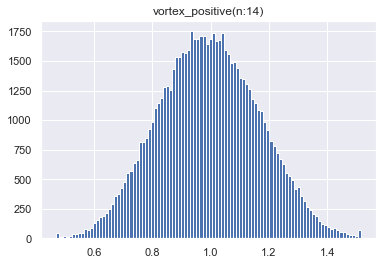

Min:0.4710678141739507
Max:1.514748602715314

75% 1.1121143717080206
80% 1.141929969098767
90% 1.388662938636315
99% 1.388662938636315
********************************************************************************************************************************************************************************************************
vortex_negative(n:14)


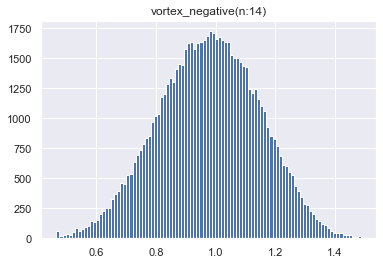

Min:0.466960084019314
Max:1.4862234209109038

75% 1.0956790123456719
80% 1.1239892183288436
90% 1.3468457689889468
99% 1.3468457689889468
********************************************************************************************************************************************************************************************************
vortex_positive(n:14)_logroc(2)


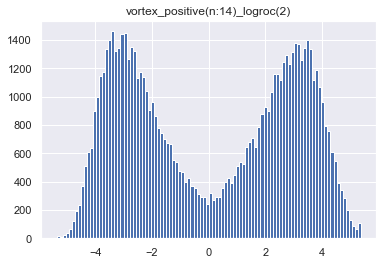

Min:-5.37
Max:5.37

75% 3.54
80% 3.7
90% 4.84
99% 4.84
********************************************************************************************************************************************************************************************************
vortex_negative(n:14)_logroc(2)


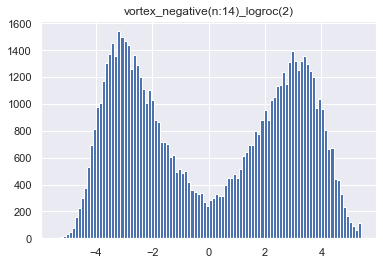

Min:-5.4
Max:5.4

75% 3.52
80% 3.68
90% 4.84
99% 4.84
********************************************************************************************************************************************************************************************************
vortex_positive(n:14)_logroc(5)


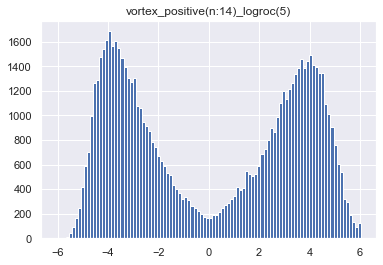

Min:-6.04
Max:6.04

75% 4.19
80% 4.34
90% 5.49
99% 5.49
********************************************************************************************************************************************************************************************************
vortex_negative(n:14)_logroc(5)


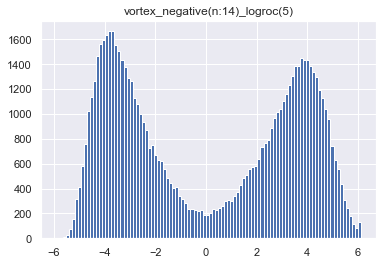

Min:-5.9
Max:6.115950000000012

75% 4.17
80% 4.33
90% 5.53
99% 5.53
********************************************************************************************************************************************************************************************************
vortex_positive(n:14)_logroc(10)


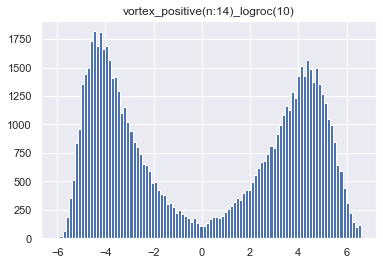

Min:-6.03
Max:6.59

75% 4.66
80% 4.81
90% 6.02
99% 6.02
********************************************************************************************************************************************************************************************************
vortex_negative(n:14)_logroc(10)


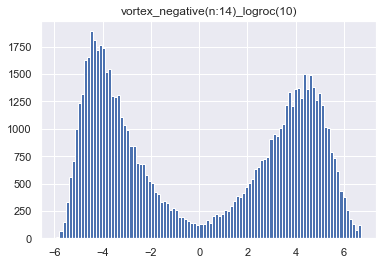

Min:-5.92
Max:6.705950000000012

75% 4.65
80% 4.81
90% 6.09
99% 6.09
********************************************************************************************************************************************************************************************************
vortex_positive(n:24)


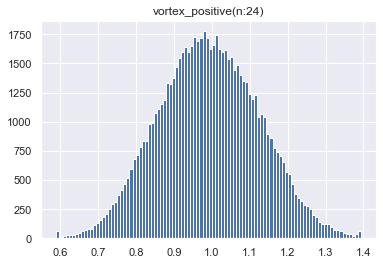

Min:0.5896959839257316
Max:1.3929626589569375

75% 1.0835740419795858
80% 1.1062917972202242
90% 1.2994011445363902
99% 1.2994011445363902
********************************************************************************************************************************************************************************************************
vortex_negative(n:24)


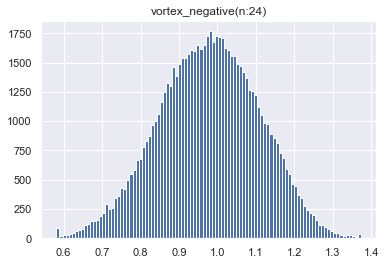

Min:0.5812705188054083
Max:1.372806554390991

75% 1.068904593639552
80% 1.091064229390254
90% 1.2611878525497038
99% 1.2611878525497038
********************************************************************************************************************************************************************************************************
vortex_positive(n:24)_logroc(2)


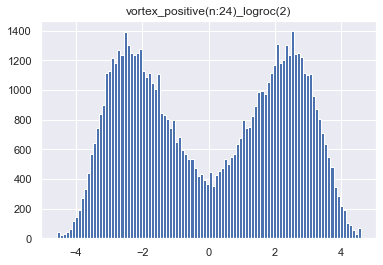

Min:-4.59
Max:4.59

75% 2.85
80% 3.0
90% 4.07
99% 4.07
********************************************************************************************************************************************************************************************************
vortex_negative(n:24)_logroc(2)


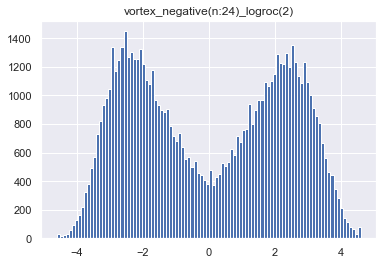

Min:-4.61
Max:4.61

75% 2.83
80% 2.98
90% 4.07
99% 4.07
********************************************************************************************************************************************************************************************************
vortex_positive(n:24)_logroc(5)


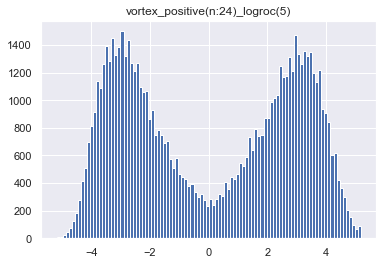

Min:-5.1919000000000235
Max:5.1919000000000235

75% 3.47
80% 3.62
90% 4.69
99% 4.69
********************************************************************************************************************************************************************************************************
vortex_negative(n:24)_logroc(5)


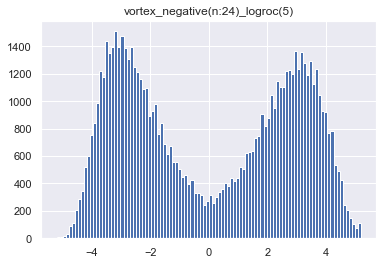

Min:-5.195950000000012
Max:5.195950000000012

75% 3.45
80% 3.61
90% 4.7
99% 4.7
********************************************************************************************************************************************************************************************************
vortex_positive(n:24)_logroc(10)


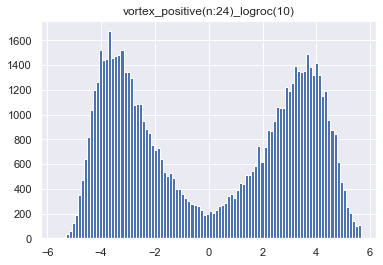

Min:-5.655950000000012
Max:5.655950000000012

75% 3.93
80% 4.08
90% 5.15
99% 5.15
********************************************************************************************************************************************************************************************************
vortex_negative(n:24)_logroc(10)


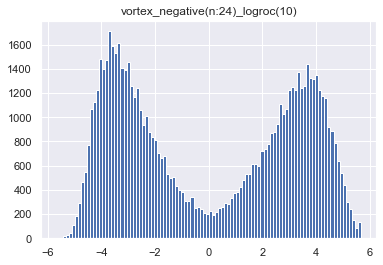

Min:-5.67
Max:5.67

75% 3.92
80% 4.08
90% 5.19
99% 5.19
********************************************************************************************************************************************************************************************************
vortex_positive(n:32)


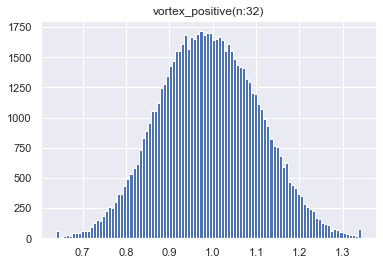

Min:0.6396210660304916
Max:1.3414466293175367

75% 1.0710463185089445
80% 1.090570847631149
90% 1.2568370037279128
99% 1.2568370037279128
********************************************************************************************************************************************************************************************************
vortex_negative(n:32)


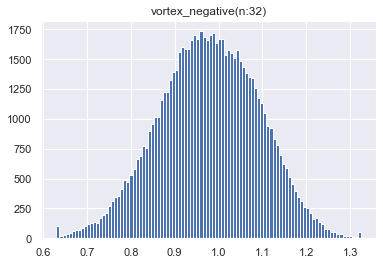

Min:0.6301427503891054
Max:1.3243714239974218

75% 1.0582476749877938
80% 1.0769423432375644
90% 1.226349366247971
99% 1.226349366247971
********************************************************************************************************************************************************************************************************
vortex_positive(n:32)_logroc(2)


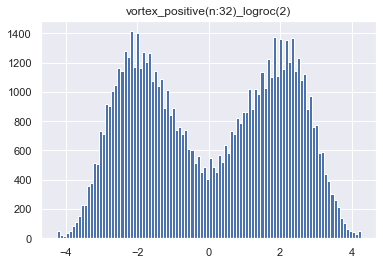

Min:-4.255950000000012
Max:4.255950000000012

75% 2.5
80% 2.64
90% 3.7
99% 3.7
********************************************************************************************************************************************************************************************************
vortex_negative(n:32)_logroc(2)


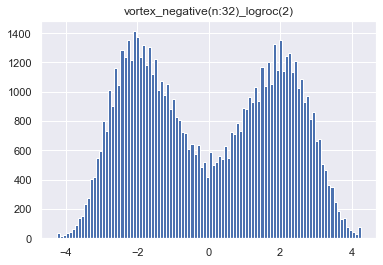

Min:-4.26
Max:4.26

75% 2.48
80% 2.62
90% 3.71
99% 3.71
********************************************************************************************************************************************************************************************************
vortex_positive(n:32)_logroc(5)


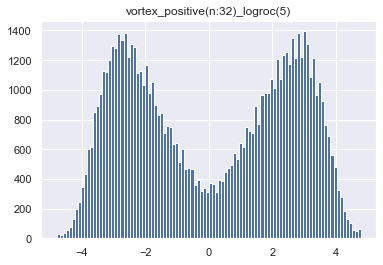

Min:-4.79
Max:4.79

75% 3.1
80% 3.25
90% 4.27
99% 4.27
********************************************************************************************************************************************************************************************************
vortex_negative(n:32)_logroc(5)


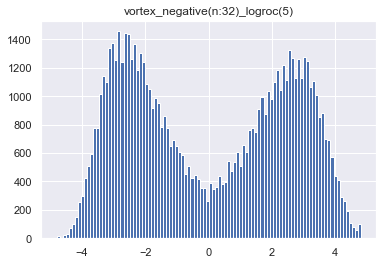

Min:-4.805950000000012
Max:4.805950000000012

75% 3.09
80% 3.23
90% 4.31
99% 4.31
********************************************************************************************************************************************************************************************************
vortex_positive(n:32)_logroc(10)


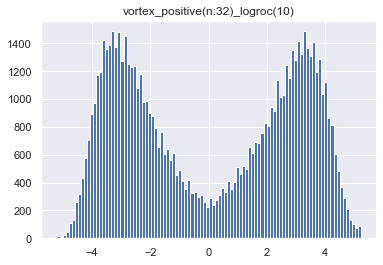

Min:-5.22
Max:5.22

75% 3.55
80% 3.69
90% 4.72
99% 4.72
********************************************************************************************************************************************************************************************************
vortex_negative(n:32)_logroc(10)


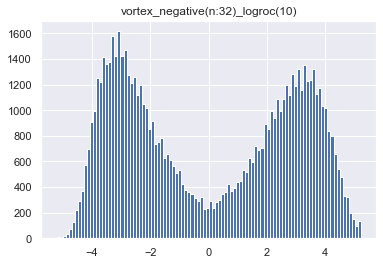

Min:-5.22
Max:5.22

75% 3.55
80% 3.7
90% 4.77
99% 4.77
********************************************************************************************************************************************************************************************************


In [37]:
from src.calulation.BollingerBand import BollingerBand
from src.calulation.PpoBuilder import PpoBuilder
from src.calulation.RsiBuilder import RsiBuilder
from src.calulation.VortexBuilder import VortexBuilder
import src.calulation.utils as ta_utils

from src.calulation.indicator_builder import build_indicatrors

rocs = [2, 5, 10] # 2, 5, 10
property = 'close'
indicators = [
    VortexBuilder(14, rocs=rocs),
    VortexBuilder(24, rocs=rocs),
    VortexBuilder(32, rocs=rocs),
    #
    # RsiBuilder(14, 8,  rocs=rocs),
    # RsiBuilder(24, 8,  rocs=rocs),
    # RsiBuilder(32, 5,  rocs=rocs),

    # BollingerBand(property=property, n=14, rocs=rocs),
    # BollingerBand(property=property, n=24, rocs=rocs),
   # BollingerBand(property=property, n=32, rocs=rocs),

    #PpoBuilder(slow=30, fast=10, smooth=5, rocs=rocs)
]

df = min1_df.copy()
basic_price = df.iloc[0].low
basic_volume = df.volume.min()
ta_utils.normilize_data_(df, basic_price, basic_volume)


min1_df_with_indicators = build_indicatrors(df, indicators)
min1_df_with_indicators = min1_df_with_indicators.iloc[2000:-1] # drop warmup

# print(min1_df_with_indicators.iloc[-1].to_dict())
raw_columns = {'date', 'low', 'close', 'high', 'open', 'volume'}
for col in min1_df_with_indicators.columns:
    if col in raw_columns:
        continue

    print(f"{col}")
    plt.title(col)
    min1_df_with_indicators[col].hist(bins=100)
    plt.show()
    print(f"Min:{min1_df_with_indicators[col].min()}")
    print(f"Max:{min1_df_with_indicators[col].max()}")
    abs = np.abs(min1_df_with_indicators[col])
    print()
    print("75%", np.percentile(abs, 75))
    print("80%", np.percentile(abs, 80))
    print("90%", np.percentile(abs, 99))
    print("99%", np.percentile(abs, 99))
    print("*"*200)